In [1]:
import numpy as np
import pandas as pd
import datetime
from collections import OrderedDict
from collections import Counter
import re

In [2]:
nimess_eventlog = pd.read_csv('nimess_features.csv', low_memory=False)

In [3]:
anino_eventlog = pd.read_csv('anino_eventlog.csv', low_memory=False)

In [4]:
trfl_eventlog = pd.read_csv('trfl_eventlog.csv', low_memory=False)
nsml_eventlog = pd.read_csv('nsml_eventlog_aggregated.csv', low_memory=False)

In [5]:
nimess_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
anino_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)
nsml_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)
trfl_eventlog.drop([ 'Unnamed: 0'], axis=1, inplace=True)

In [7]:
pasient = pd.read_csv('pasient_dec_23.csv')

Readmission.............................................................................................................At end of the second last epsiode

In [18]:
nimess_eventlog['readmission'] = nimess_eventlog.apply(lambda row: 1 if row['care_level_code'] == 1 and 0 < row['time_to_last'] <= 720 else 0, axis=1)

In [19]:
nimess_eventlog['readmission'].value_counts()

0    1202565
1     125620
Name: readmission, dtype: int64

In [20]:
nimess_eventlog_sorted = nimess_eventlog.sort_values(by=['ppid', 'inndatotid'])

In [22]:
nimess_eventlog_sorted['temp_rank'] = nimess_eventlog_sorted.groupby('ppid').cumcount(ascending=False)

# Extracting the second last episode data.
last_episode = nimess_eventlog_sorted[nimess_eventlog_sorted['temp_rank'] == 0]

# Dropping temporary rank column from second_last_episode.
last_episode = last_episode.drop(columns=['temp_rank'])

In [23]:
last_episode['readmission'].value_counts()

0    29655
1     5936
Name: readmission, dtype: int64

In [27]:
df_features = last_episode[['ppid', 'readmission' ]].drop_duplicates()

In [28]:
df_features['readmission'].value_counts()

0    29655
1     5936
Name: readmission, dtype: int64

In [29]:
# Step 2: Identify the last and second last episode for each patient.
# We'll use a temporary column to mark the second last episode.
nimess_eventlog_sorted['temp_rank'] = nimess_eventlog_sorted.groupby('ppid').cumcount(ascending=False)

# Extracting the second last episode data.
second_last_episode = nimess_eventlog_sorted[nimess_eventlog_sorted['temp_rank'] == 1]

# Dropping temporary rank column from second_last_episode.
second_last_episode = second_last_episode.drop(columns=['temp_rank'])

In [30]:
# Step 3: Merge second_last_episode with the original df_features dataframe on patient_id.
# This assumes df_features already exists and includes patient-level features for modeling.
df_features = pd.merge(df_features, second_last_episode, on='ppid', how='left')

In [31]:
# Step 4: Handle test results, ensuring to include only the most recent tests up to the start of the last episode for each patient.
# This code snippet assumes the existence of a 'test_results' DataFrame with a 'test_date' column and that you have a way to determine the start date of the last episode for each patient.
second_last_episode_end_date = nimess_eventlog_sorted[nimess_eventlog_sorted['temp_rank'] == 1][['ppid', 'utdatotid']].rename(columns={'utdatotid': 'second_last_episode_end'})

# Merging last_episode_start_date with test_results to filter out the relevant tests.
trfl_eventlog['date_column'] = pd.to_datetime(trfl_eventlog['date_column'])
second_last_episode_end_date['second_last_episode_end'] = pd.to_datetime(second_last_episode_end_date['second_last_episode_end'])
relevant_tests = pd.merge(trfl_eventlog, second_last_episode_end_date, on='ppid')
relevant_tests = relevant_tests[relevant_tests['date_column'] < relevant_tests['second_last_episode_end']]

In [32]:
# Calculate the average test results for each test per patient
columns_to_average = ['BILIRUBIN KONJUGERT', 'BILIRUBIN TOTAL', 'BILIRUBIN UKONJUGERT', 'CRP', 'CRP-HØYSENSITIV', 'KREATININ', 'LAKTAT',
                      'LAKTAT BLODGASS', 'LAKTAT BLODGASS VENØST', 'LAKTAT PNA', 'LEUKOCYTTER', 'PH', 'PH PNA', 'PO2', 'PO2 PNA', 'TROMBOCYTTER']
trfl_avg_test_results = relevant_tests.groupby('ppid')[columns_to_average].mean().add_suffix('_average').reset_index()

# If you also need the most recent observation for each patient
trfl_latest_observation = relevant_tests.sort_values(by=['ppid', 'date_column']).drop_duplicates('ppid', keep='last')
# Now, df_avg_test_results contains the average of each test for each patient
# and df_latest_observation contains the most recent observation for each test for each patient

In [35]:
# Step 5A: Filter and aggregate microbiology test results
# Assuming 'microbiology_tests' has columns ['patient_id', 'test_date', 'test_result'] and 'test_result' indicates positive results

# Convert 'test_date' to datetime if not already
nsml_eventlog['date_column'] = pd.to_datetime(nsml_eventlog['date_column'])

# Filter microbiology tests to include only those before the start of the last episode for each patient
filtered_microbiology_tests = pd.merge(nsml_eventlog, second_last_episode_end_date, on='ppid')
filtered_microbiology_tests = filtered_microbiology_tests[filtered_microbiology_tests['date_column'] < filtered_microbiology_tests['second_last_episode_end']]

# Identify all sample type columns (exclude patient id, date, and other non-sample columns)
sample_type_columns = [col for col in nsml_eventlog.columns if col not in ['ppid', 'date_column']]

# Initialize an empty DataFrame for storing positive count results
df_positive_counts = pd.DataFrame()

df_positive_counts['ppid'] = filtered_microbiology_tests['ppid'].unique()  # Add patient_id to the DataFrame

# Loop through each sample type and count positive results
for sample_type in sample_type_columns:
    # Count positive results for each patient for the current sample type
    positive_counts = filtered_microbiology_tests[filtered_microbiology_tests[sample_type] == 'positive'].groupby('ppid').size()
    
    # Join the counts to the df_positive_counts DataFrame
    df_positive_counts = df_positive_counts.merge(positive_counts.rename(f'Positive_{sample_type}_test'), on='ppid', how='left')

df_positive_counts.fillna(0, inplace=True)  # Replace NaN with 0 for patients with no positive results

# Now, df_positive_counts contains the total positive counts for each sample type for each patient.
# This DataFrame can be merged with your features DataFrame as needed.



In [36]:
df_positive_counts

,ppid,Positive_annet_test,Positive_anus_test,Positive_bein_test,Positive_biopsi_test,Positive_blod_test,Positive_blood_culture_test_test,Positive_bronki_test,Positive_melk_test,Positive_edta_test,Positive_faeces_test,Positive_hal_test,Positive_hud_test,Positive_led_test,Positive_naso_test,Positive_plasma_test,Positive_tunge_test,Positive_urin_test,Positive_ear_test,Positive_eye_test
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30123,36346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
30124,36347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30125,36349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30126,36350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Filter ICU stays to include only those before the start date of the last episode for each patient
filtered_icu_stays = pd.merge(anino_eventlog, second_last_episode_end_date, left_on='ppid', right_on='ppid')
filtered_icu_stays = filtered_icu_stays[filtered_icu_stays['date_column'] < filtered_icu_stays['second_last_episode_end']]

# Calculate total ICU_LOS per patient
total_icu_los = filtered_icu_stays.groupby('ppid')['ICU_LOS'].sum().reset_index(name='total_ICU_LOS')
icu_last = filtered_icu_stays.sort_values('date_column').drop_duplicates('ppid', keep='last')

In [41]:
icu_last = icu_last.drop('second_last_episode_end', axis=1)

In [42]:
icu_last = icu_last.drop('date_column', axis=1)

In [43]:
# Merge all features into a single DataFrame
df_features = df_features.merge(total_icu_los, on='ppid', how='left')
df_features = df_features.merge(icu_last, on='ppid', how='left')
df_features = df_features.merge(trfl_avg_test_results, on='ppid', how='left')
df_features = df_features.merge(trfl_latest_observation, on='ppid', how='left')
df_features = df_features.merge(df_positive_counts, on='ppid', how='left')
# Now df_features contains all necessary features and labels for modeling

In [80]:
df_features.columns.tolist()

['ppid',
 'Labels',
 'urgency_code',
 'care_level_code',
 'LOS',
 'time_to_last',
 'total_los',
 'age',
 'procedure_0',
 'procedure_1',
 'procedure_2',
 'procedure_3',
 'procedure_4',
 'procedure_5',
 'procedure_6',
 'procedure_7',
 'procedure_8',
 'procedure_9',
 'procedure_A',
 'procedure_B',
 'procedure_C',
 'procedure_D',
 'procedure_E',
 'procedure_F',
 'procedure_G',
 'procedure_H',
 'procedure_I',
 'procedure_J',
 'procedure_K',
 'procedure_L',
 'procedure_M',
 'procedure_N',
 'procedure_O',
 'procedure_P',
 'procedure_Q',
 'procedure_R',
 'procedure_S',
 'procedure_T',
 'procedure_U',
 'procedure_V',
 'procedure_W',
 'procedure_X',
 'procedure_Y',
 'procedure_Z',
 'ICD_0',
 'ICD_1',
 'ICD_2',
 'ICD_3',
 'ICD_4',
 'ICD_5',
 'ICD_6',
 'ICD_7',
 'ICD_8',
 'ICD_9',
 'ICD_A',
 'ICD_B',
 'ICD_C',
 'ICD_D',
 'ICD_E',
 'ICD_F',
 'ICD_G',
 'ICD_H',
 'ICD_I',
 'ICD_J',
 'ICD_K',
 'ICD_L',
 'ICD_M',
 'ICD_N',
 'ICD_O',
 'ICD_P',
 'ICD_Q',
 'ICD_R',
 'ICD_S',
 'ICD_T',
 'ICD_U',
 'ICD_V',


In [50]:
df_features['readmission_y'].value_counts()

0.0    29411
1.0     4803
Name: readmission_y, dtype: int64

In [49]:
df_features['readmission_x'].value_counts()

0    29655
1     5936
Name: readmission_x, dtype: int64

In [51]:
df_features = df_features.rename(columns={'readmission_x': 'Labels', 'readmission_y': 'readmission'})

In [52]:
df_features = df_features.drop('date_column_x', axis=1)
df_features = df_features.drop('date_column_y', axis=1)
df_features = df_features.drop('disease_groups', axis=1)

In [53]:
df_features.prior_comorbidities

0                                         {cardiovascular}
1                      {urinarytractinfection, infection,}
2                                              {infection}
3        {organdysfunction, skinandsofttissueinfection,...
4                                              {infection}
                               ...                        
35586                                                   {}
35587                                  {cancer, infection}
35588                            {cardiovascular,, cancer}
35589                                                   {}
35590                                                  NaN
Name: prior_comorbidities, Length: 35591, dtype: object

In [55]:
df_features.fillna(0, inplace=True)

In [57]:
def count_unique_comorbidities(comorbidity_str):
    # Check if the input is not a string, return 0 (or another appropriate value)
    if not isinstance(comorbidity_str, str):
        return 0
    
    # Original logic for counting unique comorbidities
    comorbidities = [c.strip() for c in comorbidity_str.strip('{}').split(',') if c.strip()]
    return len(set(comorbidities))

# Apply the function to the 'prior_comorbidities' column
df_features['prior_comorbidities_counts'] = df_features['prior_comorbidities'].apply(count_unique_comorbidities)


In [58]:
df_features = df_features.drop('prior_comorbidities', axis=1)

In [59]:
df_features.to_csv('ReadmissioninNextepi.csv')

In [76]:
df_features.columns.tolist()

['ppid',
 'Labels',
 'inndatotid',
 'utdatotid',
 'urgency_code',
 'care_level_code',
 'LOS',
 'time_to_last',
 'total_los',
 'age',
 'procedure_0',
 'procedure_1',
 'procedure_2',
 'procedure_3',
 'procedure_4',
 'procedure_5',
 'procedure_6',
 'procedure_7',
 'procedure_8',
 'procedure_9',
 'procedure_A',
 'procedure_B',
 'procedure_C',
 'procedure_D',
 'procedure_E',
 'procedure_F',
 'procedure_G',
 'procedure_H',
 'procedure_I',
 'procedure_J',
 'procedure_K',
 'procedure_L',
 'procedure_M',
 'procedure_N',
 'procedure_O',
 'procedure_P',
 'procedure_Q',
 'procedure_R',
 'procedure_S',
 'procedure_T',
 'procedure_U',
 'procedure_V',
 'procedure_W',
 'procedure_X',
 'procedure_Y',
 'procedure_Z',
 'ICD_0',
 'ICD_1',
 'ICD_2',
 'ICD_3',
 'ICD_4',
 'ICD_5',
 'ICD_6',
 'ICD_7',
 'ICD_8',
 'ICD_9',
 'ICD_A',
 'ICD_B',
 'ICD_C',
 'ICD_D',
 'ICD_E',
 'ICD_F',
 'ICD_G',
 'ICD_H',
 'ICD_I',
 'ICD_J',
 'ICD_K',
 'ICD_L',
 'ICD_M',
 'ICD_N',
 'ICD_O',
 'ICD_P',
 'ICD_Q',
 'ICD_R',
 'ICD_S',
 

In [70]:
df_features['kjønn'].value_counts()

Mann      17889
Kvinne    16325
0          1377
Name: kjønn, dtype: int64

In [71]:
df_features['Gender'] = df_features['kjønn'].map({'Mann': 1, 'Kvinne': 0})

In [72]:
df_features['Gender'].value_counts()

1.0    17889
0.0    16325
Name: Gender, dtype: int64

In [77]:
#df_features = df_features.drop('index', axis=1)
#df_features = df_features.drop('kjønn', axis=1)
#df_features = df_features.drop('second_last_episode_end', axis=1)
df_features = df_features.drop('inndatotid', axis=1)
df_features = df_features.drop('utdatotid', axis=1)

In [81]:
df_features = df_features.drop('last_episode_date', axis=1)

In [78]:
df_features.fillna(0, inplace=True)

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming '30_day_mortality' is the target variable
X = df_features.drop('Labels', axis=1)
y = df_features['Labels']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features (important for neural networks and logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
!pip install xgboost lightgbm catboost scikit-learn keras tensorflow

     |████████████████████████████████| 1.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 69.2 MB 353 kB/s eta 0:00:012
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 2:
   command: /Users/rajeevbopche/opt/anaconda3/envs/tensorflow/bin/python /private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-standalone-pip-bop5x9x2/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-build-env-drn8ae2f/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools >= 64.0' wheel 'jupyterlab (>=3.0.6, == 3.*)' 'conan ~= 1.62'
       cwd: None
  Complete output (172 lines):
  ERROR: Exception:
  Traceback (most recent call last):
    File "/private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-standalone-pip-bop5x9x2/__env_pip__.zip/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
      yield

In [79]:
!pip3 install lightgbm

  Using cached lightgbm-4.3.0-py3-none-macosx_10_15_x86_64.macosx_11_6_x86_64.macosx_12_5_x86_64.whl (1.8 MB)


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

# Define a simple neural network model for binary classification
def build_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    #"LightGBM": LGBMClassifier(random_state=42),
   # "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Neural Network": build_nn(X_train_scaled.shape[1])
}

# Train each model and evaluate on the test set
results = {}
for name, model in models.items():
    if name == "Neural Network":  # NN requires scaled data
        model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).reshape(-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    aucpr = roc_auc_score(y_test, y_pred)  # Use AUC-PR as a proxy for AUPRC; for exact AUPRC, consider using sklearn.metrics.average_precision_score
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity,
        "AUPRC": aucpr
    }


Using TensorFlow backend.
2024-03-21 00:14:33.358596: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 00:14:33.359269: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.
/Users/rajeevbopche/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [84]:
results

{'Random Forest': {'Accuracy': 0.844922039612305,
  'Precision': 0.7333333333333333,
  'Recall': 0.1196652719665272,
  'F1 Score': 0.20575539568345322,
  'Specificity': 0.9912221471978393,
  'AUPRC': 0.5554437095821833},
 'Logistic Regression': {'Accuracy': 0.8277848012361286,
  'Precision': 0.4124293785310734,
  'Recall': 0.06108786610878661,
  'F1 Score': 0.10641399416909621,
  'Specificity': 0.9824442943956786,
  'AUPRC': 0.5217660802522326},
 'XGBoost': {'Accuracy': 0.8508217446270544,
  'Precision': 0.6189624329159212,
  'Recall': 0.2895397489539749,
  'F1 Score': 0.39452679589509687,
  'Specificity': 0.9640445644834571,
  'AUPRC': 0.626792156718716},
 'Neural Network': {'Accuracy': 0.8032026970080067,
  'Precision': 0.3976143141153082,
  'Recall': 0.33472803347280333,
  'F1 Score': 0.36347114947751025,
  'Specificity': 0.8977042538825118,
  'AUPRC': 0.6162161436776575}}

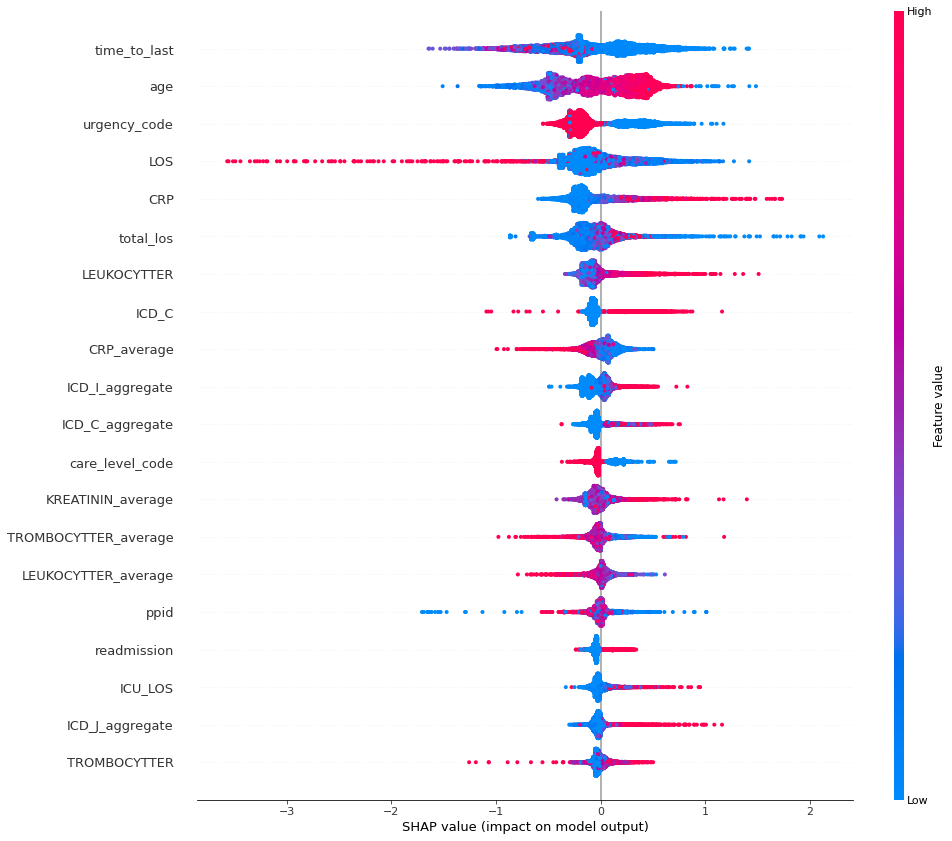

In [86]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Your data preparation step here
# X = ...  # Feature DataFrame
# y = ...  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Initialize the SHAP Explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot SHAP summary dot plot
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, show=False)

# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed
plt.savefig("Readmission_shap_summary_plot.png", bbox_inches='tight', dpi=300)

In [88]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency

# Assuming df is your DataFrame and '30_day_mortality' is the target
X = df_features.drop('Labels', axis=1)  # All features except the target
y = df_features['Labels']  # Target variable

# Separate the DataFrame into two based on the target value
group0 = df_features[df_features['Labels'] == 0]
group1 = df_features[df_features['Labels'] == 1]

# Initialize a dictionary to store test results including means
test_results = {}

# Mann-Whitney U test for numerical features + mean calculations
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    stat, p_value = mannwhitneyu(group0[feature], group1[feature], alternative='two-sided')
    mean_class_0 = group0[feature].mean()
    mean_class_1 = group1[feature].mean()
    test_results[feature] = {'Stat': stat, 'P-Value': p_value, 'Mean (Class 0)': mean_class_0, 'Mean (Class 1)': mean_class_1}

# Chi-square test for the categorical feature (gender) + mean calculations
categorical_features = ['Gender', 'care_level_code', 'urgency_code']  # Add any categorical feature names here
for feature in categorical_features:
    contingency_table = pd.crosstab(df_features[feature], y)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    mean_class_0 = group0[feature].value_counts(normalize=True).max()  # Proportion of most common category in class 0
    mean_class_1 = group1[feature].value_counts(normalize=True).max()  # Proportion of most common category in class 1
    test_results[feature] = {'Chi2 Stat': chi2, 'P-Value': p_value, 'Proportion (Class 0)': mean_class_0, 'Proportion (Class 1)': mean_class_1}

# Convert the test results to a DataFrame for easier viewing
test_results_df = pd.DataFrame(test_results).T

# Sort the results by p-value to highlight the most significant features
test_results_df = test_results_df.sort_values('P-Value')

test_results_df.to_csv('Readm_stats.csv')

# Display the results
print(test_results_df)

                       Stat        P-Value  Mean (Class 0)  Mean (Class 1)  \
urgency_code            NaN   0.000000e+00             NaN             NaN   
care_level_code         NaN   0.000000e+00             NaN             NaN   
readmission      73300270.0  1.561785e-259        0.107065        0.274259   
CRP              64015954.5  1.334696e-253       24.322301       52.303375   
LOS              65080854.5  2.731017e-250        1.530131        2.154537   
...                     ...            ...             ...             ...   
ICD_2            88016040.0   1.000000e+00        0.000000        0.000000   
ICD_1            88016040.0   1.000000e+00        0.000000        0.000000   
ICD_0            88016040.0   1.000000e+00        0.000000        0.000000   
procedure_S      88016040.0   1.000000e+00        0.000000        0.000000   
ICD_4            88016040.0   1.000000e+00        0.000000        0.000000   

                   Chi2 Stat  Proportion (Class 0)  Proportion 